# R Machine Learning Demo - Part l

## Overview of the Predictive Modeling Case
A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [101]:
library(swat)
library(ggplot2)
library(reshape2)
library(xgboost)
library(caret)
library(repr)
options(repr.plot.width=5.5, repr.plot.height=5.5)

# Connect to CAS

In [102]:
conn = CAS("server.demo.sas.com", 30570, "christine", "Student1")

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...

NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).



# CAS Session

In [103]:
cas.session.listSessions(conn)

,SessionName,UUID,State,Authentication,Userid
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Session:Thu Mar 20 16:09:56 2025,f5a6d9fe-9743-d548-b0c8-889af5acfe25,Connected,OAuth,christine


In [104]:
# Change timeout
mytime = 60*60*12
cas.session.timeout(conn,time=mytime)
cas.session.sessionStatus(conn)

list()

$state
[1] "Connected"

$`number of Connections`
[1] 1

$Timeout
[1] 43200

$ActionStatus
[1] "Action is active"

$Authenticated
[1] "Yes"

$locale
[1] "en_US"

# Load Data onto the Server

In [105]:
# Read in the hmeq CSV to an in-memory data table and create a CAS table object reference
castbl = cas.read.csv(conn, file="data/hmeq.csv", casOut = list(name="hmeq", replace=TRUE))

# Create variable for the in-memory data set name
indata = 'hmeq'

[1] "NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(christine)."


# Distributed Data

In [106]:
cas.table.tableDetails(conn,
    level="node",
    caslib="casuser",
    name=indata
)

,Node,Blocks,Active,Rows,IndexSize,DataSize,VardataSize,CompressedSize,CompressionRatio,Mapped,MappedMemory,Unmapped,UnmappedMemory,Allocated,AllocatedMemory,DeletedRows,TableLocation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,controller.sas-cas-server-default.edu.svc.cluster.local,8,8,5960,0,785334,70134,0,0,0,0,0,0,8,785352,0,CAS


In [107]:
cas.table.tableDetails(conn,
    level="block",
    caslib="casuser",
    name=indata
)

,Node,Blocks,Active,Rows,IndexSize,DataSize,VardataSize,CompressedSize,CompressionRatio,Mapped,MappedMemory,Unmapped,UnmappedMemory,Allocated,AllocatedMemory,DeletedRows,TableLocation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,814,0,106999,9319,0,0,0,0,0,0,1,107000,0,
2,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,753,0,99132,8772,0,0,0,0,0,0,1,99136,0,
3,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,736,0,97096,8776,0,0,0,0,0,0,1,97096,0,
4,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,751,0,98894,8774,0,0,0,0,0,0,1,98896,0,
5,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,721,0,95104,8584,0,0,0,0,0,0,1,95104,0,
6,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,732,0,96405,8565,0,0,0,0,0,0,1,96408,0,
7,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,727,0,95916,8676,0,0,0,0,0,0,1,95920,0,
8,controller.sas-cas-server-default.edu.svc.cluster.local,1,1,726,0,95788,8668,0,0,0,0,0,0,1,95792,0,


[1] 814 753 736 751 721 732 727 726

[1] 5960

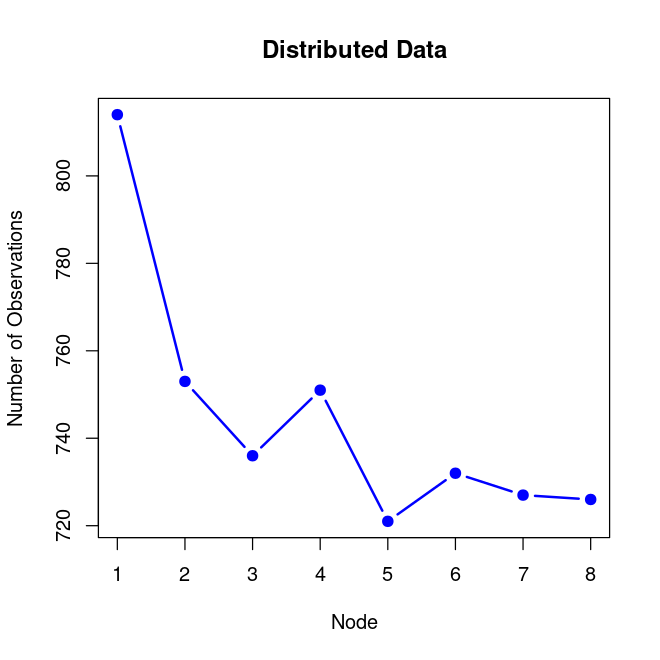

In [108]:
node_data = cas.table.tableDetails(conn,
    level = "block",
    caslib = "casuser",
    name = indata
)$TableDetails$Rows

node_data
sum(node_data)

plot(node_data, main="Distributed Data", xlab="Node", ylab='Number of Observations', col="blue", type='b', lwd=2, pch=19)

# In-Memory Data Table, CASTable Object Reference, and a casDataFrame

In [109]:
cas.table.tableInfo(conn)

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,⋯,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,HMEQ,5960,13,0,utf-8,2025-03-20T16:09:57+00:00,2025-03-20T16:09:57+00:00,2025-03-20T16:09:58+00:00,UTF8,2058106197,⋯,0,0,,,0,christine,,2025-03-20T16:09:57+00:00,2058106197,Not Specified


In [110]:
class(castbl)

[1] "CASTable"
attr(,"package")
[1] "swat"

In [111]:
class(head(castbl))

[1] "casDataFrame"
attr(,"package")
[1] "swat"

# Explore the Data

In [112]:
dim(castbl)
names(castbl)

[1] 5960   13

[1] "BAD"     "LOAN"    "MORTDUE" "VALUE"   "REASON"  "JOB"     "YOJ"    
 [8] "DEROG"   "DELINQ"  "CLAGE"   "NINQ"    "CLNO"    "DEBTINC"

In [113]:
colMeans(castbl)
mean(castbl$BAD)

BAD         LOAN      MORTDUE        VALUE          YOJ        DEROG 
1.994966e-01 1.860797e+04 7.376082e+04 1.017760e+05 8.922268e+00 2.545697e-01 
      DELINQ        CLAGE         NINQ         CLNO      DEBTINC 
4.494424e-01 1.797663e+02 1.186055e+00 2.129610e+01 3.377992e+01

[1] 0.1994966

# Wrapper

In [114]:
# Head function on the castbl object
head(castbl)

# Fetch action on the server data
cas.table.fetch(conn, table=indata, to=6)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
4,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


,_Index_,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NaN
2,2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.83333,0,14,NaN
3,3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.46667,1,10,NaN
4,4,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.33333,0,14,NaN
6,6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,101.46600,1,8,37.11361


In [115]:
# nrow function on the castbl object
nrow(castbl)

# recordCount action on the server data
cas.table.recordCount(conn, table=indata)

[1] 5960

,N
,<dbl>
1,5960


# List Available Action Sets

In [116]:
listActionSets(conn)

$actionset
 [1] "accessControl"  "accessControl"  "builtins"       "configuration" 
 [5] "dataPreprocess" "dataStep"       "percentile"     "sccasl"        
 [9] "search"         "session"        "sessionProp"    "simple"        
[13] "table"         

$label
 [1] "Access Controls"    "Access Controls"    "Builtins"          
 [4] "Server Properties"  "Data Preprocess"    "DATA Step"         
 [7] "Percentile"         "CASL Server"        "Search"            
[10] "Session Methods"    "Session Properties" "Simple Analytics"  
[13] "Table"             

$loaded
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1

$extension
 [1] "tkacon"    "casmeta"   "tkcasablt" "tkcascfg"  "tktrans"   "datastep" 
 [7] "tkcasptl"  "tkcaslsc"  "casidx"    "tkcsessn"  "tkcstate"  "tkimstat" 
[13] "tkcastab" 

$version
 [1] "V.04.00M0P03182024" "V.04.00M0P03182024" "V.04.00M0P03182024"
 [4] "V.04.00M0P03182024" "V.04.00M0P03182024" "V.04.00M0P03182024"
 [7] "V.04.00M0P03182024" "V.04.00M0P03182024" "V.04.00M0P03182024"
[10] "V.04.00M0P03182024" "V.04.00M0P03182024" "V.04.00M0P03182024"
[13] "V.04.00M0P03182024"

$product_name
 [1] "tkcas"     "tkcas"     "tkcas"     "tkcas"     "crsstat"   "tkcas"    
 [7] "crsstat"   "tkcas"     "crssearch" "tkcas"     "tkcas"     "crsstat"  
[13] "tkcas"    

$user_defined
 [1] "false" "false" "false" "false" "false" "false" "false" "false" "false"
[10] "false" "false" "false" "false"

attr(,".S3Class")
[1] "data.frame"
attr(,"name")
[1] "user_defined"
attr(,"label")
[1] "Action set information"
attr(,"title")
[1] ""
attr(,"attrs")
attr(,"attrs")$Action
[1] "actionSetInfo"

attr(,"attrs")$Actionset
[1] "builtins"

attr(,"attrs")$CreateTime
[1] 2058106198

attr(,"col.labels")
[1] "" "" "" "" "" "" ""
attr(,"col.formats")
[1] "" "" "" "" "" "" "" ""
attr(,"col.attrs")
list()
attr(,"col.sizes")
attr(,"col.sizes")[[1]]
[1] 1

attr(,"col.sizes")[[2]]
[1] 1

attr(,"col.sizes")[[3]]
[1] 1

attr(,"col.sizes")[[4]]
[1] 1

attr(,"col.sizes")[[5]]
[1] 1

attr(,"col.sizes")[[6]]
[1] 1

attr(,"col.sizes")[[7]]
[1] 1

attr(,"col.sizes")[[8]]
[1] 1

attr(,"col.sizes")[[9]]
[1] 1

attr(,"col.sizes")[[10]]
[1] 1

attr(,"col.sizes")[[11]]
[1] 1

attr(,"col.sizes")[[12]]
[1] 1

attr(,"col.sizes")[[13]]
[1] 1

attr(,"col.sizes")[[14]]
[1] 1

attr(,"col.types")
[1] "varchar" "varchar" "int32"   "varchar" "varchar" "varchar" "varchar"
attr(,"col.widths")
[1] 14 18  4  9 18  9  5
attr(,"df")
        actionset              label loaded extension            version
1   accessControl    Access Controls      1    tkacon V.04.00M0P03182024
2   accessControl    Access Controls      1   casmeta V.04.00M0P03182024
3        builtins           Builtins      1 tkcasablt V.04.00M0P03182024
4   configuration  Server Properties      1  tkcascfg V.04.00M0P03182024
5  dataPreprocess    Data Preprocess      1   tktrans V.04.00M0P03182024
6        dataStep          DATA Step      1  datastep V.04.00M0P03182024
7      percentile         Percentile      1  tkcasptl V.04.00M0P03182024
8          sccasl        CASL Server      1  tkcaslsc V.04.00M0P03182024
9          search             Search      1    casidx V.04.00M0P03182024
10        session    Session Methods      1  tkcsessn V.04.00M0P03182024
11    sessionProp Session Properties      1  tkcstate V.04.00M0P03182024
12         simple   Simple Analytics      1  tkimstat V.04.00M0P03182024
13          table              Table      1  tkcastab V.04.00M0P03182024
   product_name user_defined
1         tkcas        false
2         tkcas        false
3         tkcas        false
4         tkcas        false
5       crsstat        false
6         tkcas        false
7       crsstat        false
8         tkcas        false
9     crssearch        false
10        tkcas        false
11        tkcas        false
12      crsstat        false
13        tkcas        false

In [117]:
#http://go.documentation.sas.com/?cdcId=pgmcdc&cdcVersion=8.11&docsetId=allprodsactions&docsetTarget=actionSetsByName.htm&locale=en

# Explore the Data using CAS Actions

In [118]:
loadActionSet(conn, 'simple')

NOTE: Added action set 'simple'.

NOTE: Information for action set 'simple':

NOTE:    simple

NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables

NOTE:       numRows - Shows the number of rows in a Cloud Analytic Services table

NOTE:       summary - Generates descriptive statistics of numeric variables such as the sample mean, sample variance, sample size, sum of squares, and so on

NOTE:       correlation - Computes Pearson product-moment correlations.

NOTE:       regression - Performs a linear regression up to 3rd-order polynomials

NOTE:       crossTab - Performs one-way or two-way tabulations

NOTE:       distinct - Computes the distinct number of values of the variables in the variable list

NOTE:       topK - Returns the top-K and bottom-K distinct values of each variable included in the variable list based on a user-specified ranking order

NOTE:       groupBy - Builds BY groups in terms of the variable value combinations given the variables in

In [119]:
cas.simple.correlation(conn,
    table = indata,
    inputs = c("LOAN","VALUE","MORTDUE")
)

,Variable,N,Mean,Sum,StdDev,Minimum,Maximum
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOAN,5960,18607.97,110903500,11207.48,1100,89900
2,VALUE,5848,101776.05,595186333,57385.78,8000,855909
3,MORTDUE,5442,73760.82,401406367,44457.61,2063,399550
,Variable,LOAN,VALUE,MORTDUE,Nobs1,Nobs2,Nobs3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOAN,1.0000000,0.3353929,0.2285947,5960,5848,5442
2,VALUE,0.3353929,1.0000000,0.8756656,5848,5848,5357
3,MORTDUE,0.2285947,0.8756656,1.0000000,5442,5357,5442


In [120]:
cas.simple.distinct(conn,
    table = indata,
    inputs = names(castbl)
)

,Column,NDistinct,NMiss,Trunc
,<chr>,<dbl>,<dbl>,<dbl>
1,BAD,2,0,0
2,LOAN,540,0,0
3,MORTDUE,5054,518,0
4,VALUE,5382,112,0
5,REASON,3,252,0
6,JOB,7,279,0
7,YOJ,100,515,0
8,DEROG,12,708,0
9,DELINQ,15,580,0


In [121]:
cas.simple.freq(conn,
    table = indata,
    inputs = c("BAD","JOB","REASON")
)

,Column,NumVar,CharVar,FmtVar,Level,Frequency
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,BAD,0,,0,1,4771
2,BAD,1,,1,2,1189
3,JOB,NaN,,,1,279
4,JOB,NaN,Mgr,Mgr,2,767
5,JOB,NaN,Office,Office,3,948
6,JOB,NaN,Other,Other,4,2388
7,JOB,NaN,ProfExe,ProfExe,5,1276
8,JOB,NaN,Sales,Sales,6,109
9,JOB,NaN,Self,Self,7,193


In [122]:
cas.simple.crossTab(conn,
    table = indata,
    row = "BAD", col = "JOB"
)

,BAD,Col1,Col2,Col3,Col4,Col5,Col6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,588,823,1834,1064,71,135
2,1,179,125,554,212,38,58


In [123]:
loadActionSet(conn, 'cardinality')

NOTE: Added action set 'cardinality'.

NOTE: Information for action set 'cardinality':

NOTE:    cardinality

NOTE:       summarize - Provides actions for evaluating data cardinality



In [124]:
cas.cardinality.summarize(conn,
    table = indata,
    cardinality = list(name='card', replace=TRUE)
)

NOTE: Writing cardinality.

NOTE: status = 0.

NOTE: The Cloud Analytic Services server processed the request in 0.010001 seconds.



list()

In [125]:
cas.table.fetch(conn, table='card', to=5)
cas.table.recordCount(conn, table='card')

,_Index_,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,⋯,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,1,BAD,12,N,CLASS,ASC,N,2,5960,5960,⋯,1.504317,0.2630568,4771,Y,0,,0,1,,1
2,2,LOAN,12,N,INTERVAL,ASC,Y,20,5960,5960,⋯,2.023781,6.9325898,5890,N,NaN,,,3600,,3600
3,3,MORTDUE,12,N,INTERVAL,ASC,Y,20,5960,5442,⋯,1.814481,6.4818663,5422,N,NaN,,,5200,,5200
4,4,VALUE,12,N,INTERVAL,ASC,Y,20,5960,5848,⋯,3.053344,24.3628049,5828,N,NaN,,,16700,,16700
5,5,REASON,7,C,CLASS,ASC,N,2,5960,5708,⋯,NaN,NaN,3928,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp


,N
,<dbl>
1,13


# Define Cas Table

In [126]:
card = defCasTable(conn, tablename = "card")
head(card)
dim(card)

,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,⋯,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,BAD,12,N,CLASS,ASC,N,2,5960,5960,0,⋯,1.504317,0.2630568,4771,Y,0,,0,1,,1
2,LOAN,12,N,INTERVAL,ASC,Y,20,5960,5960,0,⋯,2.023781,6.9325898,5890,N,NaN,,,3600,,3600
3,MORTDUE,12,N,INTERVAL,ASC,Y,20,5960,5442,518,⋯,1.814481,6.4818663,5422,N,NaN,,,5200,,5200
4,VALUE,12,N,INTERVAL,ASC,Y,20,5960,5848,112,⋯,3.053344,24.3628049,5828,N,NaN,,,16700,,16700
5,REASON,7,C,CLASS,ASC,N,2,5960,5708,252,⋯,NaN,NaN,3928,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp
6,JOB,7,C,CLASS,ASC,N,6,5960,5681,279,⋯,NaN,NaN,2388,Y,NaN,Other,Other,NaN,Self,Self


[1] 13 26

# Visualize Numeric Variables Locally

In [127]:
loadActionSet(conn, 'sampling')

NOTE: Added action set 'sampling'.

NOTE: Information for action set 'sampling':

NOTE:    sampling

NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more than three portions

NOTE:       stratified - Samples a proportion of data or partitions the data into no more than three portions within each stratum

NOTE:       oversample - Samples a user-specified proportion of data from the event level and adjusts the ratio between rare events and non-rare events to a user-specified ratio

NOTE:       kfold - K-fold partitioning.



In [128]:
cas.sampling.srs(conn,
    table   = indata,
    samppct = 50,
    seed = 12345,
    partind = FALSE,
    output  = list(casOut = list(name = 'mysam', replace = T),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.

NOTE: Using SEED=12345 for sampling.



$SRSFreq
  NObs NSamp
1 5960  2980

$OutputCasTables
              casLib  Name Label Rows Columns
1 CASUSER(christine) mysam       2980      13

Warning message:
“Removed 2337 rows containing non-finite values (`stat_bin()`).”


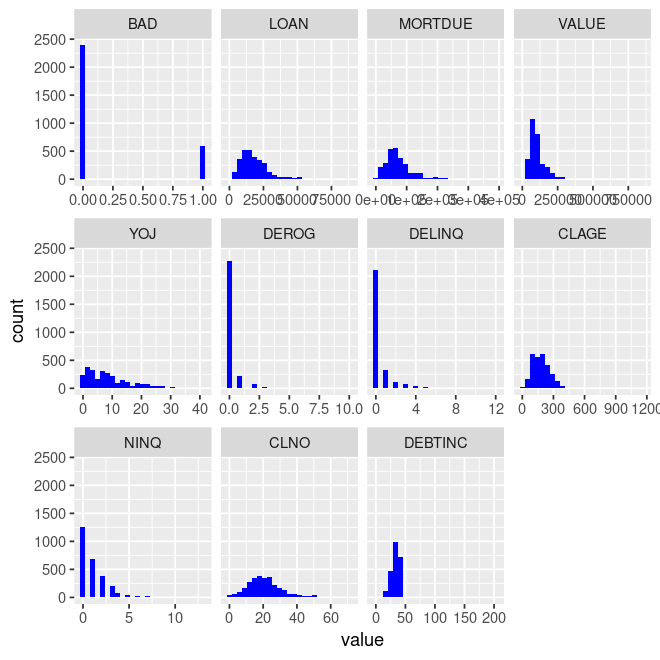

In [129]:
# Create connection object
mysam = defCasTable(conn, table='mysam')

# Bring data locally
df = to.casDataFrame(mysam)

# Use reshape2's melt to help with data formatting
df = melt(df[sapply(df, is.numeric)], id.vars=NULL)

# Plot data with ggplot
ggplot(df, aes(x = value)) +  facet_wrap(~variable,scales = 
   'free_x') + geom_histogram(fill = 'blue', bins = 25)

# Check Data for Missing Values

In [130]:
# Create a casDataFrame containing number of missing values for each variable
tbl = cas.simple.distinct(castbl)$Distinct[,c('Column', 'NMiss')]
class(tbl)
tbl

[1] "data.frame"

,Column,NMiss
,<chr>,<dbl>
1,BAD,0
2,LOAN,0
3,MORTDUE,518
4,VALUE,112
5,REASON,252
6,JOB,279
7,YOJ,515
8,DEROG,708
9,DELINQ,580


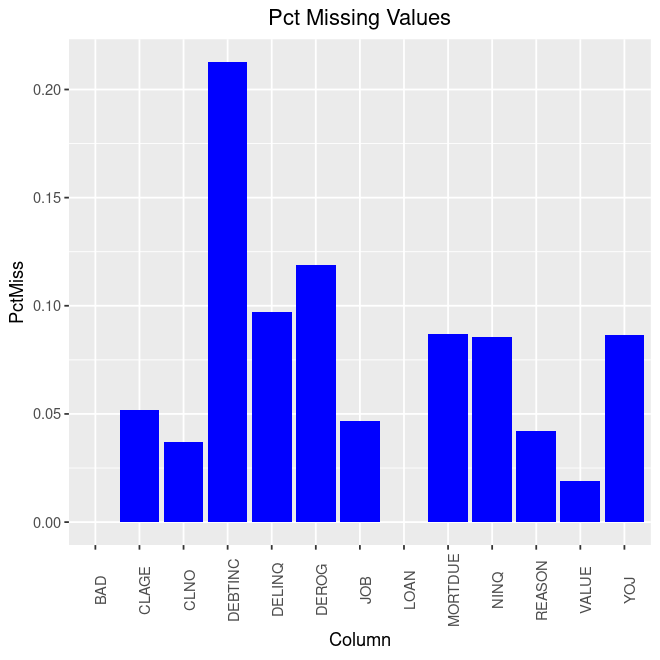

In [131]:
# Plot the percent of missing values locally
tbl$PctMiss = tbl$NMiss/nrow(castbl)
ggplot(tbl, aes(Column, PctMiss)) + geom_col(fill = 'blue') + 
   ggtitle('Pct Missing Values') + theme(plot.title = 
   element_text(hjust = 0.5), axis.text.x = element_text(angle = 90))

# Impute Missing Values

In [132]:
cas.dataPreprocess.impute(conn,
    table = indata,
    methodContinuous = 'MEDIAN',
    methodNominal    = 'MODE',
    inputs           = colnames(castbl)[-1],
    copyAllVars      = TRUE,
    casOut           = list(name = indata, replace = TRUE)
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,LOAN,Median,IMP_LOAN,5960,0,16300.00000,
2,MORTDUE,Median,IMP_MORTDUE,5442,518,65019.00000,
3,VALUE,Median,IMP_VALUE,5848,112,89235.50000,
4,REASON,Mode,IMP_REASON,5708,252,NaN,DebtCon
5,JOB,Mode,IMP_JOB,5681,279,NaN,Other
6,YOJ,Median,IMP_YOJ,5445,515,7.00000,
7,DEROG,Median,IMP_DEROG,5252,708,0.00000,
8,DELINQ,Median,IMP_DELINQ,5380,580,0.00000,
9,CLAGE,Median,IMP_CLAGE,5652,308,173.46667,


# Create Variable Shortcuts

In [133]:
# Get variable info and types
colinfo = cas.table.columnInfo(conn, table=indata)$ColumnInfo
colinfo

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<int>,<int>
1,BAD,,1,double,8,12,,0,0
2,LOAN,,2,double,8,12,,0,0
3,MORTDUE,,3,double,8,12,,0,0
4,VALUE,,4,double,8,12,,0,0
5,REASON,,5,varchar,7,7,,0,0
6,JOB,,6,varchar,7,7,,0,0
7,YOJ,,7,double,8,12,,0,0
8,DEROG,,8,double,8,12,,0,0
9,DELINQ,,9,double,8,12,,0,0


In [134]:
# Target variable is the first variable
target = colinfo$Column[1]

# Get all variables
inputs = colinfo$Column[-1]
nominals = c(target, subset(colinfo, Type == 'varchar')$Column)

# Get only imputed variables
inputs = grep('IMP_', inputs, value = T)
nominals = c(target, grep('IMP_', nominals, value = T))

target
inputs
nominals

[1] "BAD"

[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# R Machine Learning Demo - Part ll

# Split the Data into Training and Validation

In [135]:
cas.sampling.srs(conn,
    table   = indata,
    samppct = 70,
    seed = 919,
    partind = TRUE,
    output  = list(casOut = list(name = indata, replace = T),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.

NOTE: Using SEED=919 for sampling.



$SRSFreq
  NObs NSamp
1 5960  4172

$OutputCasTables
              casLib Name Label Rows Columns
1 CASUSER(christine) hmeq       5960      26

# View the partition

In [136]:
loadActionSet(conn, 'fedSql')

NOTE: Added action set 'fedSql'.

NOTE: Information for action set 'fedSql':

NOTE:    fedSql

NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution



In [137]:
# Make sure the partition worked correctly using SQL
counts = cas.fedSql.execDirect(conn, query =
    "
    SELECT _PartInd_, count(*) 
    FROM hmeq 
    GROUP BY _PartInd_;
    "
)$`Result Set`

counts
counts$Percent = counts$COUNT/sum(counts$COUNT)
counts

,_PartInd_,COUNT
,<dbl>,<dbl>
1,0,1788
2,1,4172


,_PartInd_,COUNT,Percent
,<dbl>,<dbl>,<dbl>
1,0,1788,0.3
2,1,4172,0.7


In [138]:
# Refresh the castbl object
castbl = defCasTable(conn, table=indata)

# Make sure the partition worked correctly using R code
mean(castbl$`_PartInd_`)

[1] 0.7

# Dimension Reduction - Var Reduce

In [139]:
loadActionSet(conn, 'varReduce')

NOTE: Added action set 'varReduce'.

NOTE: Information for action set 'varReduce':

NOTE:    varReduce

NOTE:       unsuper - Provides an action for performing unsupervised dimension reduction

NOTE:       super - Provides an action for performing supervised dimension reduction



In [140]:
varReduce_obj = cas.varReduce.super(conn,
    table = indata,
    target = target,
    inputs = inputs,
    nominals = nominals,
    varexp = 0.90
)

names(varReduce_obj)

[1] "Nobs"             "SelectionSummary" "SelectedEffects"

In [141]:
varReduce_obj$SelectionSummary

,Iteration,Variable,Parameter,VarExp,SSE,MSE,AIC,AICC,BIC
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,IMP_DELINQ,IMP_DELINQ,0.1200645,1.759871,0.0002953299,0.5669184,2.566919,0.5666990
2,2,IMP_DEROG,IMP_DEROG,0.1657445,1.668511,0.0002800455,0.5142806,2.514283,0.5148487
3,3,IMP_CLAGE,IMP_CLAGE,0.1904379,1.619124,0.0002718019,0.4849055,2.484909,0.4862610
4,4,IMP_DEBTINC,IMP_DEBTINC,0.2070668,1.585866,0.0002662637,0.4648222,2.464826,0.4669650
5,5,IMP_NINQ,IMP_NINQ,0.2155122,1.568976,0.0002634720,0.4547853,2.454791,0.4577156
6,6,IMP_LOAN,IMP_LOAN,0.2201275,1.559745,0.0002619659,0.4495559,2.449563,0.4532735
7,7,IMP_JOB,IMP_JOB Office,0.2242440,1.551512,0.0002606269,0.4449346,2.444944,0.4494396
8,8,IMP_CLNO,IMP_CLNO,0.2275932,1.544814,0.0002595453,0.4412791,2.441291,0.4465715
9,9,IMP_JOB,IMP_JOB Sales,0.2297767,1.540447,0.0002588551,0.4391194,2.439134,0.4451991


In [142]:
varReduce_obj$SelectedEffects
varReduce_obj$SelectedEffects$Variable

,Number,Variable,Type
,<int>,<chr>,<chr>
1,1,IMP_DELINQ,INTERVAL
2,2,IMP_DEROG,INTERVAL
3,3,IMP_CLAGE,INTERVAL
4,4,IMP_DEBTINC,INTERVAL
5,5,IMP_NINQ,INTERVAL
6,6,IMP_LOAN,INTERVAL
7,7,IMP_JOB,CLASS
8,8,IMP_CLNO,INTERVAL
9,9,IMP_REASON,CLASS


[1] "IMP_DELINQ"  "IMP_DEROG"   "IMP_CLAGE"   "IMP_DEBTINC" "IMP_NINQ"   
 [6] "IMP_LOAN"    "IMP_JOB"     "IMP_CLNO"    "IMP_REASON"  "IMP_MORTDUE"
[11] "IMP_VALUE"   "IMP_YOJ"

# Logistic Regression

In [143]:
loadActionSet(conn, 'regression')

NOTE: Added action set 'regression'.

NOTE: Information for action set 'regression':

NOTE:    regression

NOTE:       glm - Fits linear regression models using the method of least squares

NOTE:       genmod - Fits generalized linear regression models

NOTE:       logistic - Fits logistic regression models

NOTE:       logisticType3 - computes Type 3 or Joint tests that all parameters for an effect are zero

NOTE:       logisticCode - writes SAS DATA step code for computing predicted values of the fitted model

NOTE:       genmodScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       logisticScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       glmScore - creates a table on the server that contains results from scoring observations by using a fitted model

NOTE:       logisticAssociation - computes indices of rank correlation between predicted probabi

In [144]:
cas.regression.logistic(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    classVars = nominals[-1],
    model = list(depvar=target, effects=inputs, dist='binomial', link='logit'),
    store    = list(name='lr_model', replace=TRUE)
)

NOTE: Convergence criterion (FCONV=1E-7) satisfied.

NOTE: At least one element of the gradient is greater than 1e-3.

NOTE: 493943 bytes were written to the table "lr_model" in the caslib "CASUSER(christine)".



,RowId,Description,Value
,<chr>,<chr>,<chr>
1,DATA,Data Source,HMEQ
2,EVENTVAR,Response Variable (Events),BAD
3,DIST,Distribution,Binomial
4,LINK,Link Function,Logit
5,TECH,Optimization Technique,Newton-Raphson with Ridging
,RowId,Description,Value
,<chr>,<chr>,<dbl>
1,NREAD,Number of Observations Read,4172
2,NUSED,Number of Observations Used,4172


# Support Vector Machine

In [145]:
loadActionSet(conn, 'svm')

NOTE: Added action set 'svm'.

NOTE: Information for action set 'svm':

NOTE:    svm

NOTE:       svmTrain - Provides actions for support vector machines



In [146]:
cas.svm.svmTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    kernel = 'polynomial', 
    degree = 2,
    savestate = list(name = 'svm_model', replace = TRUE)
)

NOTE: SVM training is activated.

NOTE: 11014 bytes were written to the table "svm_model" in the caslib "CASUSER(christine)".



,RowId,Descr,Value,NValue
,<chr>,<chr>,<chr>,<dbl>
1,TaskType,Task Type,C_CLAS,NaN
2,Method,Optimization Technique,Interior Point,NaN
3,Scale,Scale,YES,NaN
4,Kernel,Kernel Function,Polynomial,NaN
5,degree,Kernel Degree,2,2.0e+00
6,PenaltyMethod,Penalty Method,C,NaN
7,C,Penalty Parameter,1,1.0e+00
8,MaxIter,Maximum Iterations,25,2.5e+01
9,Tolerance,Tolerance,1e-06,1.0e-06


# Decision Tree

In [147]:
loadActionSet(conn, 'decisionTree')

NOTE: Added action set 'decisionTree'.

NOTE: Information for action set 'decisionTree':

NOTE:    decisionTree

NOTE:       dtreeTrain - Trains a decision tree

NOTE:       dtreeScore - Scores a table using a decision tree model

NOTE:       dtreeSplit - Splits decision tree nodes

NOTE:       dtreePrune - Prune a decision tree

NOTE:       dtreeMerge - Merges decision tree nodes

NOTE:       dtreeCode - Generates DATA step scoring code from a decision tree model

NOTE:       forestTrain - Trains a forest. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       forestScore - Scores a table using a forest model

NOTE:       forestCode - Generates DATA step scoring code from a forest model

NOTE:       gbtreeTrain - Trains a gradient boosting tree. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       gbtreeScore - Scores a table using a gradient boosting tree model

NOTE:       gbtreeCode - Generates DATA step scoring co

In [148]:
cas.decisionTree.dtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    casOut   = list(name = 'dt_model', replace = TRUE)
)

,Descr,Value
,<chr>,<dbl>
1,Number of Tree Nodes,43.00000
2,Max Number of Branches,2.00000
3,Number of Levels,6.00000
4,Number of Leaves,22.00000
5,Number of Bins,50.00000
6,Minimum Size of Leaves,5.00000
7,Maximum Size of Leaves,3786.00000
8,Number of Variables,12.00000
9,Confidence Level for Pruning,0.25000


# Random Forest

In [149]:
cas.decisionTree.forestTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 1000,
    casOut   = list(name = 'rf_model', replace = TRUE)
)

,Descr,Value
,<chr>,<dbl>
1,Number of Trees,1000.00000
2,Number of Selected Variables (M),4.00000
3,Random Number Seed,0.00000
4,Bootstrap Percentage (%),63.21206
5,Number of Bins,50.00000
6,Number of Variables,12.00000
7,Confidence Level for Pruning,0.25000
8,Max Number of Tree Nodes,45.00000
9,Min Number of Tree Nodes,25.00000


# Gradient Boosting

In [150]:
cas.decisionTree.gbtreeTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 1000,
    casOut   = list(name = 'gbt_model', replace = TRUE)
)

,Descr,Value
,<chr>,<dbl>
1,Number of Trees,1000.000
2,Distribution,2.000
3,Learning Rate,0.100
4,Subsampling Rate,0.500
5,Number of Selected Variables (M),12.000
6,Number of Bins,50.000
7,Number of Variables,12.000
8,Max Number of Tree Nodes,31.000
9,Min Number of Tree Nodes,17.000


# Neural Network

In [151]:
loadActionSet(conn, 'neuralNet')

NOTE: Added action set 'neuralNet'.

NOTE: Information for action set 'neuralNet':

NOTE:    neuralNet

NOTE:       annTrain - Trains an artificial neural network

NOTE:       annScore - Scores a table using an artificial neural network model

NOTE:       annCode - Generates DATA step scoring code from an artificial neural network model



In [152]:
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    hiddens = list(150),
    nloOpts    = list(optmlOpt = list(maxIters = 100, 
                      fConv = 1e-10),
                      lbfgsOpt = list(numCorrections = 6)),
    casOut   = list(name = 'nn_model', replace = TRUE)
)

,Progress,Objective,Loss,FitError
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.394659,4.394659,0.55201342
2,2,1.991708,1.991708,0.18024928
3,3,1.790516,1.790516,0.17976989
4,4,1.657040,1.657040,0.17377756
5,5,1.608293,1.608293,0.16442953
6,6,1.594024,1.594024,0.16131352
7,7,1.570131,1.570131,0.16251198
8,8,1.540491,1.540491,0.16011505
9,9,1.507999,1.507999,0.14717162


# Score the Models

In [153]:
loadActionSet(conn, 'aStore')

NOTE: Added action set 'aStore'.

NOTE: Information for action set 'astore':

NOTE:    astore

NOTE:       saveas - Saves an ONNX model to an analytic store

NOTE:       extract - Extracts the saved ONNX blob from a remote saved ONNX store

NOTE:       check - Checks whether an ONNX model is valid

NOTE:       download - Downloads a remote store to a local store

NOTE:       upload - Uploads a local store to a remote store

NOTE:       describe - Describes some of the contents of the analytic store

NOTE:       score - Uses an analytic store to score an input table



In [154]:
#Score the support vector machine model
cas.astore.score(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    rstore = "svm_model",
    out = list(name="svm_scored", replace=TRUE)
)

$OutputCasTables
              casLib       Name Rows Columns
1 CASUSER(christine) svm_scored 1788       5

$Timing
                Task      Seconds    Percent
1  Loading the Store 0.0001368523 0.02047441
2 Creating the State 0.0023441315 0.35070448
3            Scoring 0.0037729740 0.56447298
4              Total 0.0066840649 1.00000000

In [155]:
#Score the logistic regression model
lr_score_obj = cas.regression.logisticScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    restore = "lr_model",
    casout = list(name="lr_scored", replace=TRUE),
    copyVars = list(target)
)

#Score the decision tree model
dt_score_obj = cas.decisionTree.dtreeScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "dt_model",
    casout = list(name="dt_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the random forest model
rf_score_obj = cas.decisionTree.forestScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "rf_model",
    casout = list(name="rf_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the gradient boosting model
gb_score_obj = cas.decisionTree.gbtreeScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "gbt_model",
    casout = list(name="gbt_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

#Score the neural network model
nn_score_obj = cas.neuralNet.annScore(conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = "nn_model",
    casout = list(name="nn_scored",replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE
)

In [156]:
#View selected fields from the output object
nn_score_obj$OutputCasTables
nn_score_obj$ScoreInfo

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(christine),nn_scored,1788,4


,Descr,Value
,<chr>,<chr>
1,Number of Observations Read,1788
2,Number of Observations Used,1788
3,Misclassification Error (%),7.9977628635


# Assess the Models

In [157]:
loadActionSet(conn, 'percentile')

NOTE: Added action set 'percentile'.

NOTE: Information for action set 'percentile':

NOTE:    percentile

NOTE:       percentile - Calculate quantiles and percentiles

NOTE:       boxPlot - Calculate quantiles, high and low whiskers, and outliers

NOTE:       assess - Assess and compare models



In [158]:
# Change the name of the prediction variable for logistic regression
cas.dataStep.runCode(conn, code="
    data lr_scored;
        set lr_scored;
        rename _PRED_ = P_BAD1;
    run;
"
)

# Add the target variable to the svm scored table
cas.dataStep.runCode(conn, code="
    data svm_scored;
        merge svm_scored(keep=P_BAD1) lr_scored(keep=BAD);
    run;
"
)

$InputCasTables
              casLib      Name Rows Columns
1 CASUSER(christine) lr_scored 1788       2

$OutputCasTables
              casLib      Name Rows Columns Append Promoted
1 CASUSER(christine) lr_scored 1788       2    NaN        N

$InputCasTables
              casLib       Name Rows Columns
1 CASUSER(christine) svm_scored 1788       5
2 CASUSER(christine)  lr_scored 1788       2

$OutputCasTables
              casLib       Name Rows Columns Append Promoted
1 CASUSER(christine) svm_scored 1788       2    NaN        N

In [159]:
# Create prediction variable name
assess_input = paste("P_", target, "1", sep = "")

# Assess the logistic regression model
lr_assess_obj = cas.percentile.assess(conn,
   table = 'lr_scored',
   inputs = assess_input,
   casout = list(name="lr_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the support vector machine model
svm_assess_obj = cas.percentile.assess(conn,
   table = 'svm_scored',
   inputs = assess_input,
   casout = list(name="svm_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the decision tree model
dt_assess_obj = cas.percentile.assess(conn,
   table = "dt_scored",
   inputs = assess_input,
   casout = list(name="dt_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the random forest model
rf_assess_obj = cas.percentile.assess(conn,
   table = "rf_scored",
   inputs = assess_input,
   casout = list(name="rf_assess",replace=TRUE),
   response = target,
   event = "1"
)

#Assess the gradient boosting model
gb_assess_obj = cas.percentile.assess(conn,
   table = "gbt_scored",
   inputs = assess_input,
   casout = list(name="gbt_assess",replace=TRUE),
   response = target,
   event = "1"
)

# Assess the neural network model
nn_assess_obj = cas.percentile.assess(conn,
   table = "nn_scored",
   inputs = assess_input,
   casout = list(name="nn_assess",replace=TRUE),
   response = target,
   event = "1"
)

In [160]:
nn_assess_obj$OutputCasTables

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(christine),nn_assess,20,21
2,CASUSER(christine),nn_assess_ROC,100,22


# View the Assess Action Output

In [161]:
cas.table.fetch(conn, table='nn_assess', to=5)
cas.table.fetch(conn, table='nn_assess_ROC', to=5)

,_Index_,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,⋯,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,P_BAD1,1,5,0.99998675,90,89,90,24.860335,25.13966,⋯,24.86034,25.13966,4.972067,5.027933,98.88889,100.00000,98.88889,100.00000,3.972067,4.027933
2,2,P_BAD1,1,10,0.99393723,90,86,90,24.022346,25.13966,⋯,48.88268,50.27933,4.888268,5.027933,95.55556,100.00000,97.22222,100.00000,3.888268,4.027933
3,3,P_BAD1,1,15,0.70316987,90,67,90,18.715084,25.13966,⋯,67.59777,75.41899,4.506518,5.027933,74.44444,100.00000,89.62963,100.00000,3.506518,4.027933
4,4,P_BAD1,1,20,0.14967667,90,38,88,10.614525,24.58101,⋯,78.21229,100.00000,3.910615,5.000000,42.22222,97.77778,77.77778,99.44444,2.910615,4.000000
5,5,P_BAD1,1,25,0.03688486,90,19,0,5.307263,0.00000,⋯,83.51955,100.00000,3.340782,4.000000,21.11111,0.00000,66.44444,79.55556,2.340782,3.000000


,_Index_,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,⋯,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_,_FNR_
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,P_BAD1,1,0.00,358,1430,0,0,1.0000000,0.0000000,⋯,1.0000000,0.2002237,0.7997763,0.3336440,0.904773,0.809546,0.9227575,0.2594171,0.7997763,0.0000000
2,2,P_BAD1,1,0.01,308,217,50,1213,0.8603352,0.8482517,⋯,0.1517483,0.8506711,0.4133333,0.6976217,0.904773,0.809546,0.9227575,0.2594171,0.1493289,0.1396648
3,3,P_BAD1,1,0.02,304,176,54,1254,0.8491620,0.8769231,⋯,0.1230769,0.8713647,0.3666667,0.7255370,0.904773,0.809546,0.9227575,0.2594171,0.1286353,0.1508380
4,4,P_BAD1,1,0.03,300,160,58,1270,0.8379888,0.8881119,⋯,0.1118881,0.8780761,0.3478261,0.7334963,0.904773,0.809546,0.9227575,0.2594171,0.1219239,0.1620112
5,5,P_BAD1,1,0.04,297,145,61,1285,0.8296089,0.8986014,⋯,0.1013986,0.8847875,0.3280543,0.7425000,0.904773,0.809546,0.9227575,0.2594171,0.1152125,0.1703911


# Bring Results to the Client

In [162]:
# Create table objects from the assess output, 
# bring data to the client, 
# and add new variable to data frame indicating model name

lr_assess_ROC = defCasTable(conn, tablename = "lr_assess_ROC")
lr_assess_ROC = to.casDataFrame(lr_assess_ROC)
lr_assess_ROC$Model = 'Logistic Regression'

svm_assess_ROC = defCasTable(conn, tablename = "svm_assess_ROC")
svm_assess_ROC = to.casDataFrame(svm_assess_ROC)
svm_assess_ROC$Model = 'Support Vector Machine'

dt_assess_ROC = defCasTable(conn, tablename = "dt_assess_ROC")
dt_assess_ROC = to.casDataFrame(dt_assess_ROC)
dt_assess_ROC$Model = 'Decision Tree'

rf_assess_ROC = defCasTable(conn, tablename = "rf_assess_ROC")
rf_assess_ROC = to.casDataFrame(rf_assess_ROC)
rf_assess_ROC$Model = 'Random Forest'

gbt_assess_ROC = defCasTable(conn, tablename = "gbt_assess_ROC")
gbt_assess_ROC = to.casDataFrame(gbt_assess_ROC)
gbt_assess_ROC$Model = 'Gradient Boosting'

nn_assess_ROC = defCasTable(conn, tablename = "nn_assess_ROC")
nn_assess_ROC = to.casDataFrame(nn_assess_ROC)
nn_assess_ROC$Model = 'Neural Network'

# Compare Confusion Matrix

In [163]:
df_assess = rbind(lr_assess_ROC, svm_assess_ROC, dt_assess_ROC, rf_assess_ROC, gbt_assess_ROC, nn_assess_ROC)
cutoff_index = round(df_assess[,3],2)==0.5
compare = df_assess[cutoff_index,]
rownames(compare) = NULL
compare[,c('Model','_TP_','_FP_','_FN_','_TN_')]

Model,_TP_,_FP_,_FN_,_TN_
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logistic Regression,132,41,226,1389
Support Vector Machine,102,19,256,1411
Decision Tree,128,30,230,1400
Random Forest,121,19,237,1411
Gradient Boosting,283,40,75,1390
Neural Network,257,42,101,1388


# Compare Misclassification

In [164]:
compare$Misclassification = 1 - compare$'_ACC_'
miss = compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) = NULL
miss

Model,Misclassification
<chr>,<dbl>
Gradient Boosting,0.06431767
Neural Network,0.07997763
Random Forest,0.14317673
Decision Tree,0.14541387
Logistic Regression,0.14932886
Support Vector Machine,0.15380313


# Compare ROC Curves

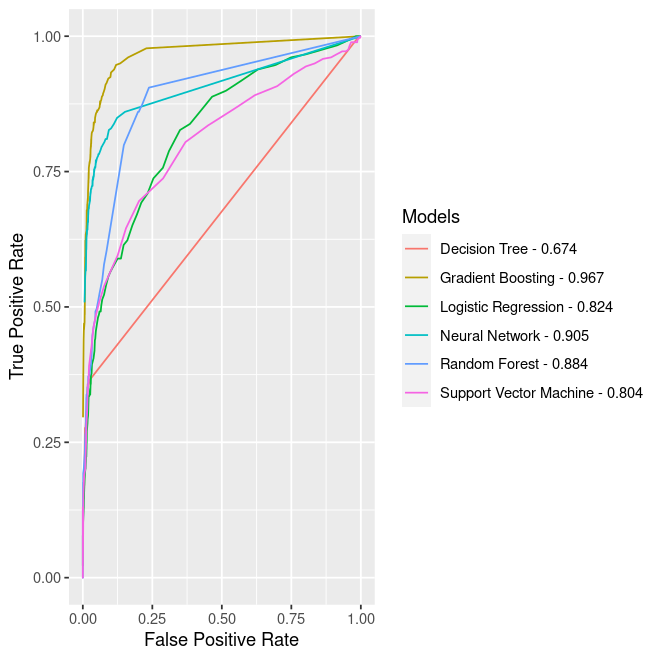

In [165]:
# Add a new column to be used as the ROC curve label
df_assess$Models = paste(df_assess$Model, round(df_assess$'_C_', 3), sep = ' - ')

#Subset the data frame with only three variables 
df_roc = df_assess[c('_FPR_', '_Sensitivity_', 'Models')]
colnames(df_roc) = c("FPR", "Sensitivity", "Models")

# Create the ROC curve
ggplot(data = df_roc, 
   aes(x = FPR, y = Sensitivity, colour = Models)) + 
   geom_line() +
   labs(x = 'False Positive Rate', y = 'True Positive Rate')

# Compare Lift Curves

In [166]:
lr_assess_lift = defCasTable(conn, tablename = "lr_assess")
lr_assess_lift = to.casDataFrame(lr_assess_lift)
lr_assess_lift$Model = 'Logistic Regression'

svm_assess_lift = defCasTable(conn, tablename = "svm_assess")
svm_assess_lift = to.casDataFrame(svm_assess_lift)
svm_assess_lift$Model = 'Support Vector Machine'

dt_assess_lift = defCasTable(conn, tablename = "dt_assess")
dt_assess_lift = to.casDataFrame(dt_assess_lift)
dt_assess_lift$Model = 'Decision Tree'

rf_assess_lift = defCasTable(conn, tablename = "rf_assess")
rf_assess_lift = to.casDataFrame(rf_assess_lift)
rf_assess_lift$Model = 'Random Forest'

gbt_assess_lift = defCasTable(conn, tablename = "gbt_assess")
gbt_assess_lift = to.casDataFrame(gbt_assess_lift)
gbt_assess_lift$Model = 'Gradient Boosting'

nn_assess_lift = defCasTable(conn, tablename = "nn_assess")
nn_assess_lift = to.casDataFrame(nn_assess_lift)
nn_assess_lift$Model = 'Neural Network'

df_assess = rbind(lr_assess_lift, svm_assess_lift, dt_assess_lift, rf_assess_lift, gbt_assess_lift, nn_assess_lift)

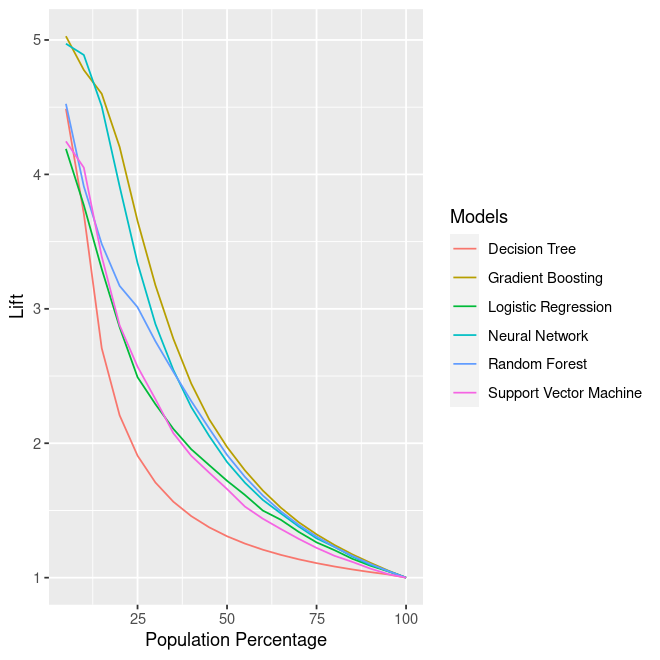

In [167]:
df_lift = df_assess[c('_Depth_', '_CumLift_', 'Model')]
colnames(df_lift) = c("Depth", "CumLift", "Models")

ggplot(data = df_lift, 
   aes(x = Depth, y = CumLift, colour = Models)) + 
   geom_line() +
   labs(x = 'Population Percentage', y = 'Lift')

# Fit an XGBoost Model in R Locally

In [168]:
# Create sample to bring to the client
cas.sampling.srs(conn,
    table   = indata,
    samppct = 75,
    seed = 12345,
    partind = FALSE,
    output  = list(casOut = list(name = 'mysam', replace = T),  copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.

NOTE: Using SEED=12345 for sampling.



$SRSFreq
  NObs NSamp
1 5960  4470

$OutputCasTables
              casLib  Name Label Rows Columns
1 CASUSER(christine) mysam       4470      26

In [169]:
# Bring data locally
mysam = defCasTable(conn, table='mysam')
df = to.casDataFrame(mysam)
df = df[,c(target, inputs, '_PartInd_')]

# Create dummy variables through one-hot encoding
df.dum = df[,nominals[-1]]
dummies = dummyVars('~ .', data = df.dum)
df.ohe = as.data.frame(predict(dummies, newdata = df))
df.all.combined = cbind(df[,-c(which(colnames(df) %in% 
   nominals[-1]))], df.ohe)

# Split into training and validation
train = df.all.combined[df.all.combined['_PartInd_'] == 1,]
valid = df.all.combined[df.all.combined['_PartInd_'] == 0,]

# Train the XGBoost model
set.seed(101112)
bst = xgboost(
    data = data.matrix(train[,-1]),
    label = data.matrix(train[,1]),
    nround = 25,
    objective = "binary:logistic",
    eta = 0.1,
    max_depth = 5,  
    subsample = 0.5,
    colsample_bytree = 0.5
)

[1]	train-logloss:0.629914 
[2]	train-logloss:0.580541 
[3]	train-logloss:0.546626 
[4]	train-logloss:0.519365 
[5]	train-logloss:0.484879 
[6]	train-logloss:0.464699 
[7]	train-logloss:0.438106 
[8]	train-logloss:0.414378 
[9]	train-logloss:0.400680 
[10]	train-logloss:0.381948 
[11]	train-logloss:0.372050 
[12]	train-logloss:0.356067 
[13]	train-logloss:0.348727 
[14]	train-logloss:0.341417 
[15]	train-logloss:0.329383 
[16]	train-logloss:0.319726 
[17]	train-logloss:0.310210 
[18]	train-logloss:0.301462 
[19]	train-logloss:0.295526 
[20]	train-logloss:0.291031 
[21]	train-logloss:0.284702 
[22]	train-logloss:0.279245 
[23]	train-logloss:0.273973 
[24]	train-logloss:0.268954 
[25]	train-logloss:0.266470 


# Score and Assess XGBoost on Validation Data

In [170]:
pred = as.numeric(predict(bst, data.matrix(valid[,-1]), missing = 'NAN') > 0.5)
Misclassification = mean(as.numeric(pred > 0.5) != valid[,1])
xgb = data.frame(cbind(Model = 'R - XGBoost', Misclassification))
xgb

Model,Misclassification
<chr>,<chr>
R - XGBoost,0.121896162528217


# Final Assessment with CAS and R Models

In [171]:
# Combine the assessments and order by most accurate on validation data
err = data.frame(rbind(miss, xgb))
err[,-1] = round(as.numeric(as.character(err[,-1])),7)
err = err[order(err[,-1]),]
rownames(err) = NULL
err

Model,Misclassification
<chr>,<dbl>
Gradient Boosting,0.0643177
Neural Network,0.0799776
R - XGBoost,0.1218962
Random Forest,0.1431767
Decision Tree,0.1454139
Logistic Regression,0.1493289
Support Vector Machine,0.1538031


# View All Data Tables in Current Session

In [172]:
cas.table.tableInfo(conn)$TableInfo[,1:3]

,Name,Rows,Columns
,<chr>,<dbl>,<dbl>
1,CARD,13,26
2,HMEQ,5960,26
3,LR_MODEL,1,2
4,SVM_MODEL,1,2
5,DT_MODEL,43,35
6,RF_MODEL,33578,41
7,GBT_MODEL,30212,31
8,NN_MODEL,2852,15
9,DT_SCORED,1788,13


# Add caslib to specify a data source

In [173]:
# Show the current location
cas.table.caslibInfo(conn, active=FALSE, caslib="casuser")

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CASUSER(christine),PATH,Personal File System Caslib,/home/christine/casuser/,,1,0,1,1,0,1,Not Specified


In [174]:
# Add CAS library named mycl
cas.table.addCaslib(conn, name="mycl", path="/workshop/EVMLOPR", dataSource="PATH", activeOnAdd = FALSE)

NOTE: Cloud Analytic Services added the caslib 'mycl'.



,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,mycl,PATH,,/workshop/EVMLOPR/,,0,1,0,0,0,0,Not Specified


In [175]:
# Show the current location
cas.table.caslibInfo(conn)

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CASUSER(christine),PATH,Personal File System Caslib,/home/christine/casuser/,,1,0,1,1,0,1,Not Specified
2,Formats,PATH,Stores user defined formats.,/cas/data/caslibs/formats/,,0,0,0,0,0,0,Not Specified
3,ModelPerformanceData,PATH,Stores performance data output for the Model Management service.,/cas/data/caslibs/modelMonitorLibrary/,,0,0,0,0,0,0,Not Specified
4,Models,PATH,Stores models created by Visual Analytics for use in other analytics or SAS Studio.,/cas/data/caslibs/models/,,0,0,0,0,0,0,Not Specified
5,Public,PATH,"Shared and writeable caslib, accessible to all users.",/cas/data/caslibs/public/,,0,0,0,0,0,0,Not Specified
6,Samples,PATH,"Stores sample data, supplied by SAS.",/cas/data/caslibs/samples/,,0,0,0,0,0,0,Not Specified
7,SystemData,PATH,"Stores application generated data, used for general reporting.",/cas/data/caslibs/sysData/,,0,0,0,0,0,0,Not Specified
8,mycl,PATH,,/workshop/EVMLOPR/,,0,1,0,0,0,0,Not Specified


# Save the Best Model

In [176]:
cas.table.save(conn, caslib = 'mycl', table = list(name = 'gbt_model'), name = 'best_model_gbt', replace = T)

NOTE: Cloud Analytic Services saved the file best_model_gbt.sashdat in caslib mycl.



$caslib
[1] "mycl"

$name
[1] "best_model_gbt.sashdat"

In [177]:
# Save the Model Attributes
cas.table.attribute(conn, caslib = 'CASUSER', table = 'gbt_model_attr', name = 'gbt_model', task='convert')
cas.table.save(conn, caslib = 'mycl', table = 'gbt_model_attr', name = 'attr', replace = T)

list()

NOTE: Cloud Analytic Services saved the file attr.sashdat in caslib mycl.



$caslib
[1] "mycl"

$name
[1] "attr.sashdat"

# Drop a CASLIB

In [178]:
cas.table.dropCaslib(conn, caslib="mycl")

NOTE: Cloud Analytic Services removed the caslib 'mycl'.



list()

# Promote Data Table to Global Scope

In [179]:
cas.table.promote(conn, caslib="casuser", name=indata)
cas.table.tableInfo(conn)

NOTE: Cloud Analytic Services promoted table HMEQ in caslib CASUSER(christine) to table hmeq in caslib CASUSER(christine).



list()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,⋯,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,CARD,13,26,0,utf-8,2025-03-20T16:09:59+00:00,2025-03-20T16:09:59+00:00,2025-03-20T16:09:59+00:00,UTF8,2058106199,⋯,0,0,,,0,christine,,,NaN,Not Specified
2,LR_MODEL,1,2,0,utf-8,2025-03-20T16:10:02+00:00,2025-03-20T16:10:02+00:00,2025-03-20T16:10:11+00:00,UTF8,2058106202,⋯,0,0,,,0,christine,,,NaN,Not Specified
3,SVM_MODEL,1,2,0,utf-8,2025-03-20T16:10:02+00:00,2025-03-20T16:10:02+00:00,2025-03-20T16:10:10+00:00,UTF8,2058106202,⋯,0,0,,,0,christine,,,NaN,Not Specified
4,DT_MODEL,43,35,0,utf-8,2025-03-20T16:10:03+00:00,2025-03-20T16:10:03+00:00,2025-03-20T16:10:11+00:00,UTF8,2058106203,⋯,0,0,,,0,christine,,,NaN,Not Specified
5,RF_MODEL,33578,41,0,utf-8,2025-03-20T16:10:04+00:00,2025-03-20T16:10:04+00:00,2025-03-20T16:10:11+00:00,UTF8,2058106204,⋯,0,0,,,0,christine,,,NaN,Not Specified
6,GBT_MODEL,30212,31,0,utf-8,2025-03-20T16:10:07+00:00,2025-03-20T16:10:07+00:00,2025-03-20T16:10:20+00:00,UTF8,2058106207,⋯,0,0,,,0,christine,,,NaN,Not Specified
7,NN_MODEL,2852,15,0,utf-8,2025-03-20T16:10:10+00:00,2025-03-20T16:10:10+00:00,2025-03-20T16:10:11+00:00,UTF8,2058106210,⋯,0,0,,,0,christine,,,NaN,Not Specified
8,DT_SCORED,1788,13,0,utf-8,2025-03-20T16:10:11+00:00,2025-03-20T16:10:11+00:00,2025-03-20T16:10:12+00:00,UTF8,2058106211,⋯,0,0,,,0,christine,,,NaN,Not Specified
9,RF_SCORED,1788,6,0,utf-8,2025-03-20T16:10:11+00:00,2025-03-20T16:10:11+00:00,2025-03-20T16:10:12+00:00,UTF8,2058106211,⋯,0,0,,,0,christine,,,NaN,Not Specified


# End the Session

In [180]:
cas.session.endSession(conn)

list()

# R Machine Learning Demo - Part lll

![title](sas_viya_logo.png)

# R Machine Learning Demo - Part lV

In [181]:
conn = CAS("server.demo.sas.com", 30570, "christine", "Student1")

NOTE: Connecting to CAS and generating CAS action functions for loaded
      action sets...

NOTE: To generate the functions with signatures (for tab completion), set 
      options(cas.gen.function.sig=TRUE).



In [182]:
cas.table.tableInfo(conn)

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,⋯,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,HMEQ,5960,26,0,utf-8,2025-03-20T16:10:01+00:00,2025-03-20T16:10:20+00:00,2025-03-20T16:10:20+00:00,UTF8,2058106201,⋯,0,0,,,0,christine,,,NaN,Not Specified


In [183]:
indata = 'hmeq'
cas.table.fetch(conn, table=indata, to=6)

,_Index_,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,⋯,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON,_PartInd_
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,⋯,0,0,1100,25860,1,39025.0,10.5,Other,HomeImp,0
2,2,1,1300,70053,68400,HomeImp,Other,7.0,0,2,⋯,2,0,1300,70053,0,68400.0,7.0,Other,HomeImp,0
3,3,1,1500,13500,16700,HomeImp,Other,4.0,0,0,⋯,0,0,1500,13500,1,16700.0,4.0,Other,HomeImp,0
4,4,1,1500,NaN,NaN,,,NaN,NaN,NaN,⋯,0,0,1500,65019,1,89235.5,7.0,Other,DebtCon,0
5,5,0,1700,97800,112000,HomeImp,Office,3.0,0,0,⋯,0,0,1700,97800,0,112000.0,3.0,Office,HomeImp,1
6,6,1,1700,30548,40320,HomeImp,Other,9.0,0,0,⋯,0,0,1700,30548,1,40320.0,9.0,Other,HomeImp,0


In [184]:
# Get variable info and types
colinfo = cas.table.columnInfo(conn, table=indata)$ColumnInfo

# Target variable is the first column
target = colinfo$Column[1]

# Get all variables
inputs = colinfo$Column[-1]
nominals = c(target, subset(colinfo, Type == 'varchar')$Column)

# Get only imputed variables
inputs = grep('IMP_', inputs, value = T)
nominals = c(target, grep('IMP_', nominals, value = T))

target
inputs
nominals

[1] "BAD"

[1] "IMP_CLAGE"   "IMP_CLNO"    "IMP_DEBTINC" "IMP_DELINQ"  "IMP_DEROG"  
 [6] "IMP_LOAN"    "IMP_MORTDUE" "IMP_NINQ"    "IMP_VALUE"   "IMP_YOJ"    
[11] "IMP_JOB"     "IMP_REASON"

[1] "BAD"        "IMP_JOB"    "IMP_REASON"

# Load a Saved Table into Memory

In [185]:
# Create a CASLIB
cas.table.addCaslib(conn, name="mycl", path="/workshop/EVMLOPR", dataSource="PATH", activeOnAdd = FALSE)

# Load table and table attributes into memory
cas.table.loadTable(conn, caslib = 'mycl', path="best_model_gbt.sashdat", casOut=list(name="gbt_model", replace=TRUE))
cas.table.loadTable(conn, caslib = 'mycl', path="attr.sashdat", casOut=list(name="gbt_model_attr", replace=TRUE))
cas.table.attribute(conn, caslib='casuser', task='add', name='gbt_model', attrtable='gbt_model_attr')

cas.table.tableInfo(conn)

NOTE: Cloud Analytic Services added the caslib 'mycl'.



,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,mycl,PATH,,/workshop/EVMLOPR/,,0,1,0,0,0,0,Not Specified


NOTE: Cloud Analytic Services made the file best_model_gbt.sashdat available as table GBT_MODEL in caslib CASUSER(christine).



$caslib
[1] "CASUSER(christine)"

$tableName
[1] "GBT_MODEL"

NOTE: Cloud Analytic Services made the file attr.sashdat available as table GBT_MODEL_ATTR in caslib CASUSER(christine).



$caslib
[1] "CASUSER(christine)"

$tableName
[1] "GBT_MODEL_ATTR"

list()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,⋯,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,GBT_MODEL,30212,31,0,utf-8,2025-03-20T16:10:21+00:00,2025-03-20T16:10:21+00:00,2025-03-20T16:10:21+00:00,UTF8,2058106221,⋯,0,0,best_model_gbt.sashdat,mycl,0,christine,,2025-03-20T16:10:19+00:00,2058106219,Not Specified
2,GBT_MODEL_ATTR,1,2,0,utf-8,2025-03-20T16:10:21+00:00,2025-03-20T16:10:21+00:00,2025-03-20T16:10:21+00:00,UTF8,2058106221,⋯,0,0,attr.sashdat,mycl,0,christine,,2025-03-20T16:10:20+00:00,2058106220,Not Specified
3,HMEQ,5960,26,0,utf-8,2025-03-20T16:10:01+00:00,2025-03-20T16:10:20+00:00,2025-03-20T16:10:21+00:00,UTF8,2058106201,⋯,0,0,,,0,christine,,,NaN,Not Specified


# Model Tuning

In [186]:
loadActionSet(conn, 'autotune')

NOTE: Added action set 'autotune'.

NOTE: Information for action set 'autotune':

NOTE:    autotune

NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum error

NOTE:       tuneForest - Automatically adjusts forest parameters to tune a model for minimum error

NOTE:       tuneDecisionTree - Automatically adjusts decision tree parameters to tune a model for minimum error

NOTE:       tuneNeuralNet - Automatically adjusts neural network parameters to tune a model for minimum error

NOTE:       tuneGradientBoostTree - Automatically adjusts gradient boosting tree parameters to tune a model for minimum error

NOTE:       tuneFactMac - Automatically adjusts factorization machine parameters to tune a model for minimum error

NOTE:       tuneBnet - Automatically adjusts Bayesian network classifier parameters to tune a model for minimum error

NOTE:       tuneTsne - Automatically adjusts t-Distributed Stochastic Neighbor Embedding algorithm p

# Forest Tuning

In [187]:
cas.autotune.tuneForest(conn,
    trainOptions = list(
        table    = list(name = indata, where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = inputs, 
        nominals = nominals,
        casOut   = list(name = 'rf_tune_model', replace = TRUE) ) ,
    tunerOptions = list(seed = 802, maxEvals = 10, maxTime = 30)
)

NOTE: Autotune is started for 'Forest' model.

NOTE: Autotune option SEARCHMETHOD='GA'.

NOTE: Autotune option MAXEVALS=10.

NOTE: Autotune option MAXTIME=30 (sec.).

NOTE: Autotune option SEED=802.

NOTE: Autotune objective is 'Misclassification Error Percentage'.

NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.

NOTE: Added action set 'decisionTree'.

         Iteration       Evals     Best Objective  Elapsed Time

                 0           1             10.951          0.84

                 1          10             10.951          2.99

NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.

NOTE: Autotune time is 3.76 seconds.



,Descr,Value
,<chr>,<dbl>
1,Number of Trees,100.00
2,Number of Selected Variables (M),4.00
3,Random Number Seed,802.00
4,Bootstrap Percentage (%),60.00
5,Number of Bins,50.00
6,Number of Variables,12.00
7,Confidence Level for Pruning,0.25
8,Max Number of Tree Nodes,337.00
9,Min Number of Tree Nodes,215.00


# Deep Neural Network

In [188]:
loadActionSet(conn,'neuralNet')

NOTE: Added action set 'neuralNet'.

NOTE: Information for action set 'neuralNet':

NOTE:    neuralNet

NOTE:       annTrain - Trains an artificial neural network

NOTE:       annScore - Scores a table using an artificial neural network model

NOTE:       annCode - Generates DATA step scoring code from an artificial neural network model



In [189]:
cas.neuralNet.annTrain(conn,
    table    = list(name = indata, where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    hiddens = list(50,40,30),
    seed = 802,
    nloOpts    = list(optmlOpt = list(maxIters = 200, 
                      fConv = 1e-10),
                      lbfgsOpt = list(numCorrections = 6)),
    casOut   = list(name = 'nn_h3_model', replace = TRUE)
)

,Progress,Objective,Loss,FitError
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.4903361,4.4903361,0.71164909
2,2,2.0335374,2.0335374,0.21883988
3,3,1.8377031,1.8377031,0.20278044
4,4,1.6904600,1.6904600,0.18192713
5,5,1.6028822,1.6028822,0.17257910
6,6,1.5065681,1.5065681,0.15891659
7,7,1.4504605,1.4504605,0.15100671
8,8,1.3945167,1.3945167,0.14046021
9,9,1.3291465,1.3291465,0.12919463


# Efficient Scoring - Looping

In [190]:
loadActionSet(conn,'decisionTree')

NOTE: Added action set 'decisionTree'.

NOTE: Information for action set 'decisionTree':

NOTE:    decisionTree

NOTE:       dtreeTrain - Trains a decision tree

NOTE:       dtreeScore - Scores a table using a decision tree model

NOTE:       dtreeSplit - Splits decision tree nodes

NOTE:       dtreePrune - Prune a decision tree

NOTE:       dtreeMerge - Merges decision tree nodes

NOTE:       dtreeCode - Generates DATA step scoring code from a decision tree model

NOTE:       forestTrain - Trains a forest. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       forestScore - Scores a table using a forest model

NOTE:       forestCode - Generates DATA step scoring code from a forest model

NOTE:       gbtreeTrain - Trains a gradient boosting tree. This action requires a SAS Visual Data Mining and Machine Learning license

NOTE:       gbtreeScore - Scores a table using a gradient boosting tree model

NOTE:       gbtreeCode - Generates DATA step scoring co

In [191]:
models = c('gbt','rf_tune','nn_h3')
actions = c('cas.decisionTree.gbtreeScore','cas.decisionTree.forestScore','cas.neuralNet.annScore')

# Create function to score a given model
score.func = function(model){
    return(list( conn,
    table    = list(name = indata, where = '_PartInd_ = 0'),
    model = paste0(model, '_model'),
    casout = list(name=paste0(model, '_scored'),replace=TRUE),
    copyVars = list(target),
    encodename = TRUE,
    assessonerow = TRUE) )
}

# Loop over the models and actions
for(i in 1:length(models)){
    print(models[i])
    params = score.func(models[i])
    obj = do.call(actions[i],params)
    print(obj$ScoreInfo[3,])
}

[1] "gbt"
                        Descr                            Value
3 Misclassification Error (%)                     6.4317673378
[1] "rf_tune"
                        Descr                            Value
3 Misclassification Error (%)                     10.402684564
[1] "nn_h3"
                        Descr                            Value
3 Misclassification Error (%)                     8.2214765101


# Efficient Assessment - Looping

In [192]:
loadActionSet(conn,'percentile')

NOTE: Added action set 'percentile'.

NOTE: Information for action set 'percentile':

NOTE:    percentile

NOTE:       percentile - Calculate quantiles and percentiles

NOTE:       boxPlot - Calculate quantiles, high and low whiskers, and outliers

NOTE:       assess - Assess and compare models



In [193]:
# Create function to assess given model
assess.func = function(model){
    cas.percentile.assess(conn,
        table = paste0(model, '_scored'),
        inputs = paste("P_", target, "1", sep = ""),
        casout = list(name=paste0(model, '_assess'),replace=TRUE),
        response = target,
        event = "1")
}

# Loop over the models
for(i in 1:length(models)){
    obj = assess.func(models[i])
    print(obj$OutputCasTables)
}

              casLib           Name Rows Columns
1 CASUSER(christine)     gbt_assess   20      21
2 CASUSER(christine) gbt_assess_ROC  100      22
              casLib               Name Rows Columns
1 CASUSER(christine)     rf_tune_assess   20      21
2 CASUSER(christine) rf_tune_assess_ROC  100      22
              casLib             Name Rows Columns
1 CASUSER(christine)     nn_h3_assess   20      21
2 CASUSER(christine) nn_h3_assess_ROC  100      22


# Create Confusion Matrix

In [194]:
# Create function to bring assess tables to the client
assess_local_roc = function(model){
    castbl.obj = defCasTable(conn, tablename = paste0(model,'_assess_ROC'))
    local.tbl = to.casDataFrame(castbl.obj)
    local.tbl$Model = model
    return(local.tbl)
}

# Bring result tables to the client in a loop
df_assess_roc = NULL
for(i in 1:length(models)){
    df_assess_roc = rbind(df_assess_roc,assess_local_roc(models[i]))
}

cutoff_index = round(df_assess_roc[,3],2)==0.5
compare = df_assess_roc[cutoff_index,]
rownames(compare) = NULL
compare[,c('Model','_TP_','_FP_','_FN_','_TN_')]

Model,_TP_,_FP_,_FN_,_TN_
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
gbt,283,40,75,1390
rf_tune,226,54,132,1376
nn_h3,253,42,105,1388


# Compare Misclassification

In [195]:
compare$Misclassification = 1 - compare$'_ACC_'
miss = compare[order(compare$Misclassification), c('Model','Misclassification')]
rownames(miss) = NULL
miss

Model,Misclassification
<chr>,<dbl>
gbt,0.06431767
nn_h3,0.08221477
rf_tune,0.10402685


# Compare ROC Curve

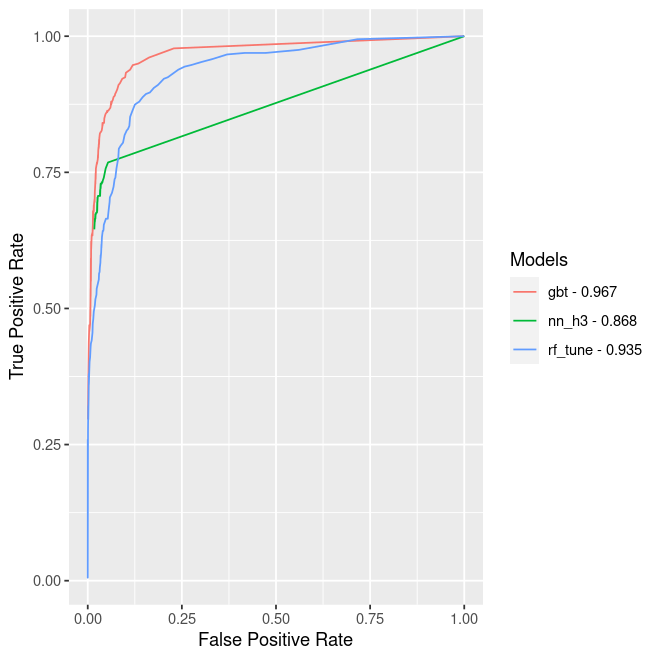

In [196]:
# Add a new column to be used as the ROC curve label
df_assess_roc$Models = paste(df_assess_roc$Model, round(df_assess_roc$'_C_', 3), sep = ' - ')

#Subset the data frame with only three variables 
df_roc = df_assess_roc[c('_FPR_', '_Sensitivity_', 'Models')]
colnames(df_roc) = c("FPR", "Sensitivity", "Models")

# Create the ROC curve
ggplot(data = df_roc, 
   aes(x = FPR, y = Sensitivity, colour = Models)) + 
   geom_line() +
   labs(x = 'False Positive Rate', y = 'True Positive Rate')

# Compare Lift Curves

In [197]:
# Create function to bring assess results to the client
assess_local_lift = function(model){
    castbl.obj = defCasTable(conn, tablename = paste0(model,'_assess'))
    local.tbl = to.casDataFrame(castbl.obj)
    local.tbl$Model = model
    return(local.tbl)
}

# Bring results to client in a loop
df_assess_lift = NULL
for(i in 1:length(models)){
    df_assess_lift = rbind(df_assess_lift,assess_local_lift(models[i]))
}

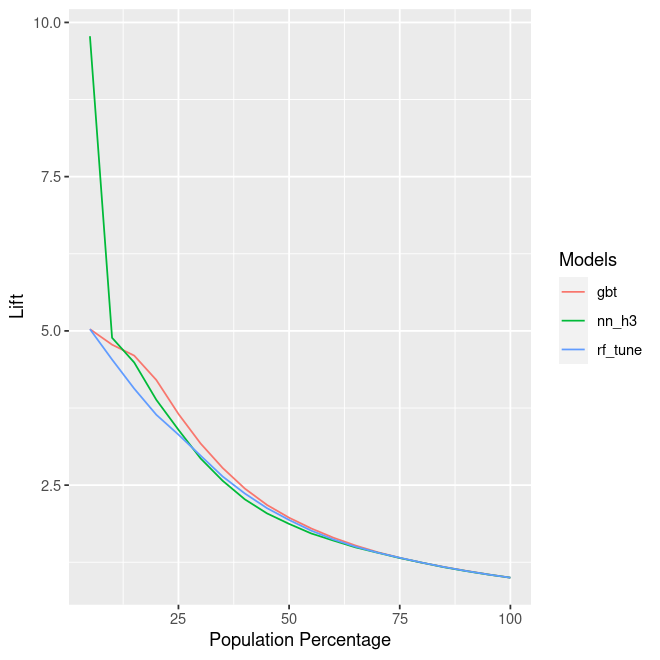

In [198]:
#Subset the data frame with only three variables 
df_lift = df_assess_lift[c('_Depth_', '_CumLift_', 'Model')]
colnames(df_lift) = c("Depth", "CumLift", "Models")

# Create the Lift curve
ggplot(data = df_lift, 
   aes(x = Depth, y = CumLift, colour = Models)) + 
   geom_line() +
   labs(x = 'Population Percentage', y = 'Lift')

# Drop Table from Memory

In [199]:
cas.table.dropTable(conn, table=indata)

NOTE: Cloud Analytic Services dropped table hmeq from caslib CASUSER(christine).



list()

# End the Session

In [200]:
cas.session.endSession(conn)

list()